In [1]:
import scrapy
import scrapy.crawler as crawler
from scrapy.utils.log import configure_logging
from multiprocessing import Process, Queue
from twisted.internet import reactor
from collections import Counter
import logging
import json
import re
import os
import pandas as pd
import numpy as np
import gc
import copy

from tqdm.auto import tqdm

from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers.models.gpt2.modeling_gpt2 import GPT2LMHeadModel
from transformers import TrainingArguments, Trainer
from transformers import pipeline

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from torch.utils.data import BatchSampler, RandomSampler

from bs4 import BeautifulSoup
from lyricsgenius import Genius
import pickle

import nltk
from nltk.tokenize import wordpunct_tokenize
nltk.download('punkt')

import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger('nlp')
logger.setLevel(logging.INFO)

[nltk_data] Downloading package punkt to /home/masdevas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Fetch sentences

In [2]:
def get_web_data(function):
    def f(q):
        try:
            json_data = function()
            q.put(json.dumps(json_data))
        except Exception as e:
            q.put(e)
    q = Queue()
    p = Process(target=f, args=(q,))
    p.start()
    result = q.get()
    p.join()
    gc.collect()
    try:
        json_data = json.loads(result)
    except:
        raise result
    return json_data

## Rap texts parsing

In [3]:
def read_genius_token():
    with open('genius_token.txt', 'r') as f:
        token = f.readline().strip()
    return token

In [4]:
def get_rap_data_extended():
    genius = Genius(read_genius_token(), timeout=60)
    storage = {}
    try:
        class RapExtendedSpider(scrapy.Spider):
            name = "rap_extended_checker"
            start_urls = [
                'https://www.allmusic.com/style/gangsta-rap-ma0000002611/artists?1651103019828'
            ]

            def parse(self, response, depth=0):
                resp = response.xpath("//div[@class='artist-highlight info-grid']//div[@class='artist']/text()")
                for item in resp:
                    artist_name = item.get().strip()
                    if len(artist_name) > 0:
                        try:
                            artist = genius.search_artist(artist_name, max_songs=150)
                        except:
                            continue
                        storage[artist_name] = []
                        for song in artist.songs:
                            storage[artist_name].append(song.lyrics)
                
        runner = crawler.CrawlerRunner()
        deferred = runner.crawl(RapExtendedSpider)
        deferred.addBoth(lambda _: reactor.stop())
        reactor.run()
        return storage
    except Exception as e:
        return {'exception' : str(e)}

In [5]:
storage_file = 'storage.pkl'
def is_rawdata_exist(storage_file):
    return os.path.exists(storage_file)
    # return False

if is_rawdata_exist(storage_file):
    print('LOADING')
    with open(storage_file, 'rb') as f:
        storage = pickle.load(f)
else:
    print('FROM WEB')
    storage = {}  
#     storage['usagov'] = get_web_data(get_usagov_rss_data)
#     storage['joke'] = get_web_data(get_joke_rss_data)
#     storage['rap'] = get_web_data(get_rap_data)
    storage['rap'] = get_web_data(get_rap_data_extended)
    with open(storage_file, 'wb') as f:
        pickle.dump(storage, f)


LOADING


# Preprocess sentences for HuggingFace

In [6]:
storage_to_process = copy.deepcopy(storage)

map_labels = {'rap' : 0}

words_limit = 22
words_at_least = 10

stop_symbols = set(['...', '.', '?', '!', '!!!', '?!', '?!'])

def join_rap_sentences(local_lines, lines_in_group):
    rap_sentences = []
    idx = 0
    while idx < len(local_lines):
        line = local_lines[idx].strip().lower()
        if len(line) == 0:
            del local_lines[idx]
            continue
        if idx + lines_in_group > len(local_lines):
            res_proc_item = line
        else:
            second_line = local_lines[idx + 1].strip().lower()
            if len(second_line) == 0:
                del local_lines[idx + 1]
                continue
            res_proc_item = line + ' ' + second_line
        res_proc_item = res_proc_item.replace(',', '')
        splitted = res_proc_item.split(' ')[:words_limit]
        if len(splitted) >= words_at_least:
            joined = ' '.join(splitted)
            end_empty = True
            for token in stop_symbols:
                if joined.endswith(token):
                    end_empty = False
                    break
            if end_empty:
                joined += '.'
            
            rap_sentences.append(joined)
        idx += lines_in_group
    return rap_sentences

# TODO how to have a deal with slang?
def get_approx_sentences_from_lyrics(lyrics, local_processed_data):
    couplets = re.split('\[.*\]' ,lyrics)
    for couplet in couplets:
        local_lines = couplet.split('\n')
        
        if len(local_lines) == 1:
            continue
        lines_in_group = 2
        rap_sentences = join_rap_sentences(local_lines, lines_in_group)
        local_processed_data.extend(rap_sentences)

def get_data_lyrics(substorage, topic_key):
    local_processed_data = []
    for lyrics_list in substorage.values():
        for lyrics in lyrics_list:
            get_approx_sentences_from_lyrics(lyrics, local_processed_data)
    local_processed_labels = [map_labels[topic_key]] * len(local_processed_data)
    with open(f'tmp_{topic_key}.json', 'w') as f:
        json.dump({'section' : local_processed_data}, f, indent=4, sort_keys=True)
    return local_processed_data, local_processed_labels

processed_data = []
processed_labels = []
for topic_key in map_labels.keys():
    if topic_key == 'rap':
        local_processed_data, local_processed_labels = get_data_lyrics(storage_to_process[topic_key], topic_key)
        processed_data.extend(local_processed_data)
        processed_labels.extend(local_processed_labels)
    else:
        raise Exception(f'Unknown topic_key: {topic_key}')


In [7]:
df_text_data = pd.DataFrame({'text' : processed_data, 'label' : processed_labels})

In [8]:
df_text_data

,text,label
0,i am a nightmare walkin' psychopath talkin' ki...,0
1,livin' life like a firecracker quick is my fus...,0
2,red or blue cuz or blood it just don't matter ...,0
3,the gangs of l.a. will never die - just multiply.,0
4,you see they hit us then we hit them then we h...,0
...,...,...
138314,with they **** ***** attitudes why it's gotta ...,0
138315,i don't owe you chick you wasn't with me when ...,0
138316,even if you was you wouldn't shoot the stick w...,0
138317,know you a hatin lil **** always talking other...,0


In [9]:
df_text_data['text'].apply(lambda x: len(x.split(' '))).value_counts()

22    19892
18    12911
17    12609
16    12526
19    11595
15    11168
20    10220
14     9938
13     8425
21     8292
12     7880
11     6694
10     6169
Name: text, dtype: int64

# Analyse common starts and continuations

In [10]:
def analyse_subseqs(data, len_main_subseq, len_extra_subseq, count_main_seqs, count_extra_seqs):
    set_main_seqs = {}
    for line in data['text']:
        splited_sentence = line[:-1].split(' ')
        for word_idx in range(len(splited_sentence)):
            if word_idx + len_main_subseq + len_extra_subseq > len(splited_sentence):
                break
            main_subseq = ' '.join(splited_sentence[word_idx:word_idx+len_main_subseq])
            if main_subseq not in set_main_seqs.keys():
                set_main_seqs[main_subseq] = 1
            else:
                set_main_seqs[main_subseq] += 1
    sorted_main_seqs_counted = sorted(list(set_main_seqs.items()), key=lambda x: -x[1])
    sorted_main_seqs = [sorted_main_seqs_counted[idx] for idx in range(count_main_seqs)]
    
    preresult = {key : [] for key in sorted_main_seqs}
    for main_key, count in sorted_main_seqs:
        splitted_main_key = main_key.split(' ')
        for line in data['text']:
            splited_sentence = line[:-1].split(' ')
            for word_idx in range(len(splited_sentence)):
                if word_idx + len_main_subseq + len_extra_subseq > len(splited_sentence):
                    break
                is_main_eq = True
                for main_word, extra_word in zip(splitted_main_key, splited_sentence[word_idx:word_idx+len_main_subseq]):
                    if main_word != extra_word:
                        is_main_eq = False
                        break
                if not is_main_eq:
                    continue
                extra_subseq = ' '.join(splited_sentence[word_idx+len_main_subseq:word_idx+len_main_subseq+len_extra_subseq])
                preresult[(main_key, count)].append(extra_subseq)
    
    result = {key : [] for key in sorted_main_seqs}
    for key, collection in preresult.items():
        common_extras = Counter(collection).most_common(count_extra_seqs)
        result[key] = common_extras
    return result
        

In [11]:
analyse_subseqs(df_text_data, 2, 1, 5, 5)

{('in the', 11599): [('hood', 424),
  ('back', 404),
  ('house', 399),
  ('air', 298),
  ('game', 296)],
 ('on the', 6422): [('block', 280),
  ('streets', 192),
  ('floor', 156),
  ('mic', 136),
  ('corner', 125)],
 ('to the', 5550): [('top', 101),
  ('beat', 96),
  ('game', 74),
  ('west', 72),
  ('side', 67)],
 ('i got', 4540): [('a', 753),
  ('the', 477),
  ('my', 381),
  ('to', 249),
  ('it', 169)],
 ('you know', 4513): [('what', 693),
  ('i', 464),
  ('the', 332),
  ('how', 258),
  ('that', 227)]}

In [12]:
chosen_data = df_text_data[df_text_data['text'].str.contains('in the hood') | df_text_data['text'].str.contains('in the back') | df_text_data['text'].str.contains('in the house') | df_text_data['text'].str.contains('in the air') | df_text_data['text'].str.contains('in the game')]
sampled_index = chosen_data.index
subsamples_data = df_text_data.drop(index=sampled_index).sample(n=10000)
subsamples_data = pd.concat([subsamples_data, chosen_data], ignore_index=True)
subsamples_data

,text,label
0,back and forth with the gangster glide started...,0
1,when i'm all alone 'cause you're not home (woo...,0
2,got cris' on pop henny wit no chaser and mami ...,0
3,and we got the workers choppin' rock fiends by...,0
4,on on on rollin on you better keep rollin on.,0
...,...,...
11885,i'm heavy in the hood 'cause i got that weight...,0
11886,i'm heavy in the hood 'cause i got that weight...,0
11887,(what up elder?) i'm heavy in the hood 'cause ...,0
11888,(they already know they can't keep up with you...,0


In [13]:
analyse_subseqs(subsamples_data, 2, 1, 5, 5)

{('in the', 2831): [('hood', 424),
  ('back', 404),
  ('house', 399),
  ('air', 298),
  ('game', 296)],
 ('on the', 583): [('streets', 34),
  ('block', 28),
  ('street', 14),
  ('mic', 14),
  ('floor', 13)],
 ('to the', 451): [('top', 12),
  ('beat', 8),
  ('streets', 8),
  ('head', 7),
  ('side', 7)],
 ('i got', 413): [('a', 56),
  ('the', 45),
  ('my', 44),
  ('that', 30),
  ('to', 22)],
 ('the hood', 410): [("'cause", 21),
  ('i', 20),
  ('they', 19),
  ('and', 15),
  ('are', 12)]}

In [14]:
generation_start = "in the"

# HuggingFace transformer is coming!

## Prepare dataset

In [15]:
hf_dataset = Dataset.from_pandas(chosen_data)

In [16]:
hf_dataset

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 1890
})

In [17]:
hf_dataset[1000]

{'text': "so you're in the back of me just listen and learn because you'll all get a chance or maybe a turn.",
 'label': 0,
 '__index_level_0__': 76418}

In [18]:
model_name = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_name)
type(model)

transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel

In [19]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    return tokenizer(examples["text"], padding='max_length', truncation=True, max_length=words_limit, return_tensors='pt')

tokenized_datasets = hf_dataset.map(tokenize_function)
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/1890 [00:00<?, ?ex/s]

In [20]:
cpu = torch.device("cpu")
device = torch.device("cuda")

def generate_data(generation_start, model, tokenizer, num_return_sequences):
    gc.collect()
    torch.cuda.empty_cache()    
    model_cpu = model.to(cpu)
    generator = pipeline('text-generation', model=model_cpu, tokenizer=tokenizer, temperature=0.1)
    generated = generator(generation_start, max_length=words_limit, num_return_sequences=num_return_sequences)
    for idx, item in enumerate(generated):
        print(f' Item #{idx}:', item['generated_text'].strip().replace('\n',''))
    gc.collect()
    torch.cuda.empty_cache()
    

generate_data(generation_start, model, tokenizer, 10)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Item #0: in the middle of the night, and I was just sitting there, and I was like, 'Oh my
 Item #1: in the middle of the night."I'm not sure if I'm going to be able to
 Item #2: in the middle of the night."I'm not sure if I'm going to be able to
 Item #3: in the middle of the night."I'm not going to be able to sleep tonight," he
 Item #4: in the middle of the night, and I was in the middle of the night. I was in the middle
 Item #5: in the middle of the night, and I was in the middle of the night. I was in the middle
 Item #6: in the middle of the night, and I was in the middle of the night, and I was in the
 Item #7: in the middle of the night, and I was in a state of shock. I was in a state of
 Item #8: in the middle of the night, and I was just sitting there, and I was like, 'Oh my
 Item #9: in the middle of the night."I'm not sure if I'm going to be able to


In [21]:
model.save_pretrained("model_storage")
model.device

device(type='cpu')

In [23]:
trained_model = GPT2LMHeadModel.from_pretrained("model_storage").to(device)

gc.collect()
torch.cuda.empty_cache()
def train():
    def check_weights_cum_norm(model):
        cum_norm = 0
        for name, W in model.named_parameters():
            cum_norm += W.norm(2)
        return cum_norm

    def eval_on_loader(trained_model, loader):
        with torch.no_grad():
            losses = []
            for batch in train_dataloader:
                ids = torch.stack(batch['input_ids'][0]).to(device)
                outputs = trained_model(input_ids=ids)
                logits = outputs['logits']
                sentences = logits.transpose(0, 1)
                labels = ids.transpose(0, 1)

                for sentence, label in zip(sentences, labels):
                    sentence_cloned = sentence.clone()
                    label_cloned = label.clone()
                    torch.nn.functional.relu(sentence_cloned, inplace=True)
                    losses.append(criterion(sentence_cloned, label_cloned))
            return sum(losses)

    batch_size = 32
    train_dataloader = DataLoader(tokenized_datasets, shuffle=True, batch_size=batch_size)
    optimizer = AdamW(trained_model.parameters(), lr=0.000001)
    scheduler = ExponentialLR(optimizer, gamma=0.85)

    criterion = CrossEntropyLoss()
    num_epochs = 20
    progress_bar_epoch = tqdm(range(num_epochs))

    num_batches = len(tokenized_datasets) // batch_size
    if len(tokenized_datasets) % batch_size:
        num_batches += 1
    gpt2_losses = []
    for epoch in range(num_epochs):
        train_loss = eval_on_loader(trained_model, train_dataloader)
        print(f'Epoch {epoch} started. Eval on train: {train_loss}. Cum norm: {check_weights_cum_norm(trained_model)}')
        gpt2_losses.append(train_loss.item())
        for batch in train_dataloader:
            optimizer.zero_grad()
            ids = torch.stack(batch['input_ids'][0]).to(device)
            outputs = trained_model(input_ids=ids)
            logits = outputs['logits']
            sentences = logits.transpose(0, 1)
            labels = ids.transpose(0, 1)
            losses = []
            for sentence, label in zip(sentences, labels):
                sentence_cloned = sentence.clone()
                label_cloned = label.clone()
                with torch.no_grad():
                    torch.nn.functional.relu(sentence_cloned, inplace=True)
                losses.append(criterion(sentence_cloned, label_cloned))

            res_loss = sum(losses) / len(losses)

            res_loss.backward()
            torch.nn.utils.clip_grad_norm_(trained_model.parameters(), 0.25)
            optimizer.step()
            del ids, outputs, logits, sentences, labels
            gc.collect()
            torch.cuda.empty_cache()
        progress_bar_epoch.update(1)
        scheduler.step()
    generate_data(generation_start, trained_model, tokenizer, 10)
    return gpt2_losses

gpt2_losses = train()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 started. Eval on train: 20455.9453125. Cum norm: 9528.4931640625
Epoch 1 started. Eval on train: 20455.61328125. Cum norm: 9528.5283203125
Epoch 2 started. Eval on train: 20452.052734375. Cum norm: 9528.5703125
Epoch 3 started. Eval on train: 20350.099609375. Cum norm: 9528.6025390625
Epoch 4 started. Eval on train: 20179.2109375. Cum norm: 9528.6328125
Epoch 5 started. Eval on train: 20291.38671875. Cum norm: 9528.671875
Epoch 6 started. Eval on train: 20376.5546875. Cum norm: 9528.703125
Epoch 7 started. Eval on train: 20407.05078125. Cum norm: 9528.73046875
Epoch 8 started. Eval on train: 20407.998046875. Cum norm: 9528.7529296875
Epoch 9 started. Eval on train: 20406.02734375. Cum norm: 9528.7734375
Epoch 10 started. Eval on train: 20404.48828125. Cum norm: 9528.79296875
Epoch 11 started. Eval on train: 20409.623046875. Cum norm: 9528.80859375
Epoch 12 started. Eval on train: 20405.83203125. Cum norm: 9528.82421875
Epoch 13 started. Eval on train: 20394.93359375. Cum norm: 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


 Item #0: in the the the the the the the the the the the the the the the the the the the the the
 Item #1: in the the the the the the the the the the the the the the the the the the the the the
 Item #2: in the the the the the the the the the the the the the the the the the the the the the
 Item #3: in the the the the the the the the the the the the the the the the the the the the the
 Item #4: in the the the the the the the the the the the the the the the the the the the the the
 Item #5: in the the the the the the the the the the the the the the the the the the the the the
 Item #6: in the the the the the the the the the the the the the the the the the the the the the
 Item #7: in the the the the the the the the the the the the the the the the the the the the the
 Item #8: in the the the the the the the the the the the the the the the the the the the the the
 Item #9: in the the the the the the the the the the the the the the the the the the the the the


Text(0.5, 1.0, 'Loss for epoch')

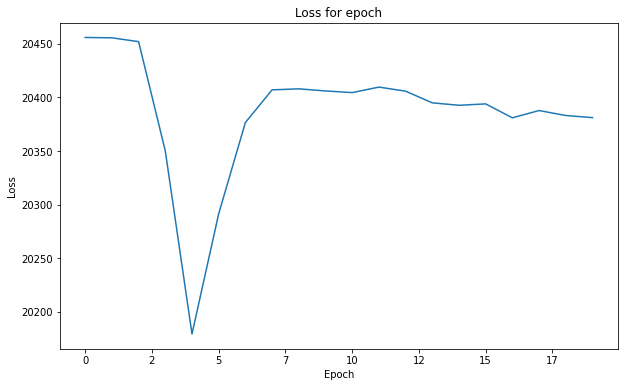

In [24]:
num_epochs = 20
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
metrics_df = pd.DataFrame({'Loss' : gpt2_losses, 'Epoch' : [idx for idx in range(num_epochs)]})
axes.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
sns.lineplot(data=metrics_df, y='Loss', x='Epoch', ax=axes)
axes.set_title('Loss for epoch')

In [25]:
del trained_model
gc.collect()
torch.cuda.empty_cache()

## Summary

Need to git into fine-fitting GPT2 deeper. Results are not good for now.

# RNN-based network

In [26]:
cpu = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float32

In [27]:
class RNNModel(nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size, dtype=dtype, device=device),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size, dtype=dtype, device=device))

In [28]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        data,
        sequence_length
    ):
        self.train_df = data
        self.sequence_length = sequence_length
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}

        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        text = self.train_df['text'].str.cat(sep=' ')
        return text.split(' ')

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.sequence_length], dtype=torch.long, device=device),
            torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1], dtype=torch.long, device=device),
        )

In [38]:
def train(dataset, model, batch_size, sequence_length, max_epochs):
    model.train()
    dataloader = DataLoader(dataset, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=0.001)
    losses = []
    progress_bar_epoch = tqdm(range(max_epochs))
    for epoch in range(max_epochs):
        state_h, state_c = model.init_state(sequence_length)

        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()
        progress_bar_epoch.update(1)
        
        # Eval
        with torch.no_grad():
            local_losses = []
            for batch, (x, y) in enumerate(dataloader):
                y_pred, (state_h, state_c) = model(x, (state_h, state_c))
                loss = criterion(y_pred.transpose(1, 2), y).detach().item()
                state_h = state_h.detach()
                state_c = state_c.detach()
                local_losses.append(loss)
            losses.append(sum(local_losses) / len(local_losses))
            print('Loss:', losses[-1])
        gc.collect()
        torch.cuda.empty_cache()
    return losses


In [39]:
def predict(dataset, model, text, next_words=10, sentences_count=10):
    model.eval()

    sentences = []
    for sentence_number in range(sentences_count):
        words = text.split(' ')
        state_h, state_c = model.init_state(len(words))        
        for i in range(0, next_words):
            x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]], device=device)
            y_pred, (state_h, state_c) = model(x, (state_h, state_c))

            last_word_logits = y_pred[0][-1]
            p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()
            word_index = np.random.choice(len(last_word_logits), p=p)
            words.append(dataset.index_to_word[word_index])
        sentences.append(' '.join(words))
    return sentences

In [40]:
batch_size = 512
sequence_length = 7
max_epochs = 50

dataset = Dataset(subsamples_data, sequence_length)
model = RNNModel(dataset).to(device)
rnnmodel_losses = train(dataset, model, batch_size, sequence_length, max_epochs)

  0%|          | 0/50 [00:00<?, ?it/s]

Loss: 7.022284302009544
Loss: 6.809778588677421
Loss: 6.629134669521738
Loss: 6.513660735890345
Loss: 6.42966286543057
Loss: 6.373067394731009
Loss: 6.315290740298741
Loss: 6.247657624598082
Loss: 6.161425924543197
Loss: 6.101483059413542
Loss: 6.047153238112552
Loss: 5.980212228552339
Loss: 5.937773416490119
Loss: 5.96207544404238
Loss: 5.8754516041218325
Loss: 5.847995290296332
Loss: 5.815798257208113
Loss: 5.791129127371735
Loss: 5.718700500914288
Loss: 5.692583308002066
Loss: 5.674070111386062
Loss: 5.653235460901018
Loss: 5.626087978406606
Loss: 5.6209270857312355
Loss: 5.619382070405834
Loss: 5.641821304553656
Loss: 5.566472973315244
Loss: 5.537402569945089
Loss: 5.458705756264894
Loss: 5.470052897022461
Loss: 5.456377739833696
Loss: 5.454246841711441
Loss: 5.445400017167106
Loss: 5.44966743561217
Loss: 5.441196030166549
Loss: 5.475529805052704
Loss: 5.486502378725159
Loss: 5.464949283503034
Loss: 5.455759821809488
Loss: 5.423226798246355
Loss: 5.475510696469224
Loss: 5.473018140

In [51]:
gc.collect()
torch.cuda.empty_cache()
generated_sentences = predict(dataset, model, text=generation_start, sentences_count=3)
for sentence in generated_sentences:
    print(sentence)

in the mcdonald's  ho snort wack streiht lactose. hate in on
in the worry thirsty travel test day boot inside you at? everybody
in the cards didn't rob dogg or real man they still down?


Text(0.5, 1.0, 'Loss for epoch')

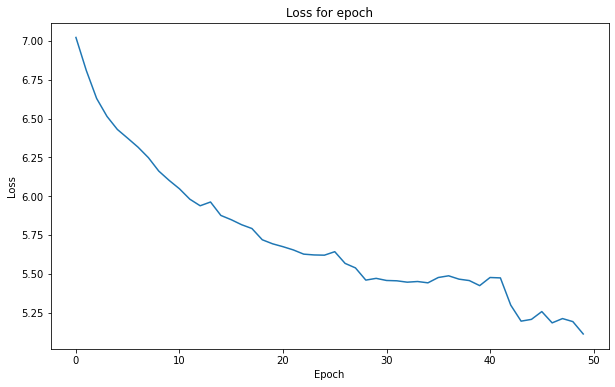

In [44]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
metrics_df = pd.DataFrame({'Loss' : rnnmodel_losses, 'Epoch' : [idx for idx in range(max_epochs)]})
axes.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
sns.lineplot(data=metrics_df, y='Loss', x='Epoch', ax=axes)
axes.set_title('Loss for epoch')

## Summary

Works well :)

In [52]:
torch.save(model.state_dict(), 'gangsta-nn')